### Load The Dataset

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("generated_dataset.csv")
data.head()

,Wellhead Temp. (C),Wellhead Press (psi),MMCFD- gas,BOPD (barrel of oil produced per day),BWPD (barrel of water produced per day),BSW - basic solid and water (%),CO2 mol. (%) @ 25 C & 1 Atm.,Gas Grav.,CR-corrosion defect
0,53.35,1105.13,12.87,1378.93,2812.62,75.64,3.3628,0.7205,0.2245
1,72.25,1026.31,3.42,1028.75,919.92,44.21,3.8679,0.8940,0.2262
2,65.08,722.96,6.23,2017.92,1212.42,17.55,2.3552,0.7661,0.2305
3,60.71,1557.23,11.71,558.22,1716.09,65.79,1.7253,0.7738,0.2303
4,46.19,1304.42,8.58,1280.47,1929.22,37.45,1.8327,0.7611,0.2202


### Data Preprocessing and Analysis

In [14]:
data['leak_status']=data['CR-corrosion defect']
data = data.rename(columns = {'CR-corrosion defect':"CRD"}, inplace=False)

data['leak_status']=data['leak_status'].astype('object')

# classififying the data classes into 4 categories
data.loc[(data.CRD<0.150), 'leak_status']= 0
data.loc[(data.CRD>=0.150)&(data.CRD<0.200), 'leak_status']= 1
data.loc[(data.CRD>=0.200)&(data.CRD<0.250), 'leak_status']= 2
data.loc[(data.CRD>=0.250), 'leak_status']= 3
data = data.drop('CRD', axis=1)

data['leak_status']=data['leak_status'].astype('category')

# Create a binary 'leak' column
data['leak'] = data['leak_status'].apply(lambda x: 1 if x > 0 else 0)

data.head()

,Wellhead Temp. (C),Wellhead Press (psi),MMCFD- gas,BOPD (barrel of oil produced per day),BWPD (barrel of water produced per day),BSW - basic solid and water (%),CO2 mol. (%) @ 25 C & 1 Atm.,Gas Grav.,leak_status,leak
0,53.35,1105.13,12.87,1378.93,2812.62,75.64,3.3628,0.7205,2,1
1,72.25,1026.31,3.42,1028.75,919.92,44.21,3.8679,0.8940,2,1
2,65.08,722.96,6.23,2017.92,1212.42,17.55,2.3552,0.7661,2,1
3,60.71,1557.23,11.71,558.22,1716.09,65.79,1.7253,0.7738,2,1
4,46.19,1304.42,8.58,1280.47,1929.22,37.45,1.8327,0.7611,2,1


In [15]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Summary statistics
summary_statistics = data.describe()
print("Summary statistics:\n", summary_statistics)

# Class distribution
class_distribution = data['leak_status'].value_counts()
print("Class distribution:\n", class_distribution)

Missing values in each column:
 Wellhead Temp. (C)                         0
Wellhead Press (psi)                       0
MMCFD- gas                                 0
BOPD (barrel of oil produced per day)      0
BWPD (barrel of water produced per day)    0
BSW - basic solid and water (%)            0
CO2 mol. (%) @ 25 C & 1 Atm.               0
Gas Grav.                                  0
leak_status                                0
leak                                       0
dtype: int64
Summary statistics:
        Wellhead Temp. (C)  Wellhead Press (psi)    MMCFD- gas  \
count        10292.000000          10292.000000  10292.000000   
mean            57.352401           1361.783583      8.851533   
std              9.423529            559.275420      4.968737   
min             41.070000            382.080000      0.230000   
25%             49.220000            880.000000      4.570000   
50%             57.360000           1364.900000      8.880000   
75%             65.412500    

## Handling Data Imbalance

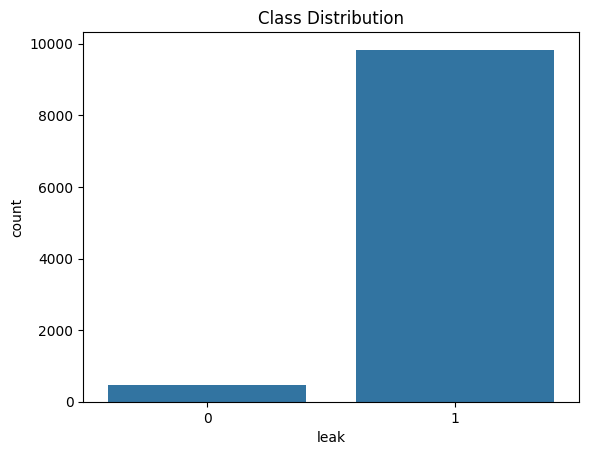

In [16]:
# Visualize class distribution
import matplotlib.pyplot as plt
import seaborn as sns


class_labels = ['No Leak', 'Leak']

sns.countplot(x='leak', data=data)
plt.title('Class Distribution')
plt.show()

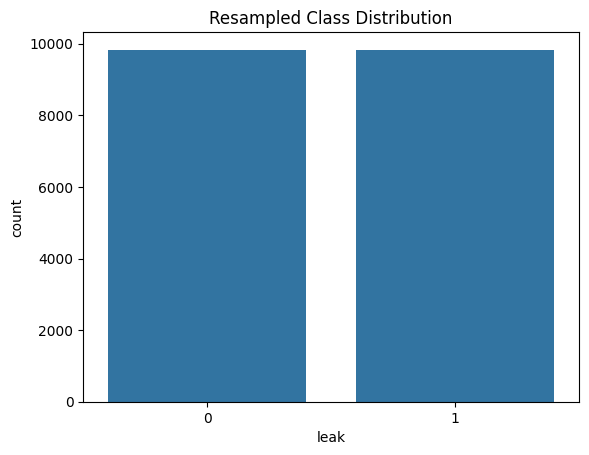

Leak Status
Leak       9832
No Leak    9832
Name: count, dtype: int64


In [17]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Split the dataset into features and target for binary classification
X = data.drop(columns=['leak_status', 'leak'])
y = data['leak']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Apply SMOTE to handle imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Visualize resampled class distribution
sns.countplot(x=y_resampled)
plt.title('Resampled Class Distribution')
plt.show()

y_resampled_series = pd.Series(y_resampled, name='Leak Status')

print(y_resampled_series.value_counts().rename(index={i: class_labels[i] for i in range(len(class_labels))}))

In [18]:
from sklearn.model_selection import train_test_split

# Split into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Further split the training set into training and validation sets (80-20 split of the training set)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint

# Define kfold cross validtor
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(random_state=42)

# Define hyperparameters to tune
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': randint(10, 100),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

# Perform random search
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=kfold, n_jobs=-1, scoring='accuracy', verbose=2)
random_search.fit(X_train, y_train)

# best parameters and estimator
print("Best Parameters: ", random_search.best_params_)
print("Best Score from Grid Search:", random_search.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=39, max_features=log2, min_samples_leaf=8, min_samples_split=17, n_estimators=325; total time=  13.4s
[CV] END bootstrap=True, max_depth=39, max_features=log2, min_samples_leaf=8, min_samples_split=17, n_estimators=325; total time=  13.4s
[CV] END bootstrap=True, max_depth=39, max_features=log2, min_samples_leaf=8, min_samples_split=17, n_estimators=325; total time=  14.1s
[CV] END bootstrap=True, max_depth=84, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=560; total time=  24.5s
[CV] END bootstrap=True, max_depth=84, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=560; total time=  24.6s
[CV] END bootstrap=True, max_depth=84, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=560; total time=  25.0s
[CV] END bootstrap=True, max_depth=84, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=560; t

Validation Accuracy: 0.9717190975532253
Validation ROC-AUC Score: 0.9968993118467532
Classification Report:
               precision    recall  f1-score   support

     No Leak       0.98      0.96      0.97      1573
        Leak       0.96      0.98      0.97      1574

    accuracy                           0.97      3147
   macro avg       0.97      0.97      0.97      3147
weighted avg       0.97      0.97      0.97      3147



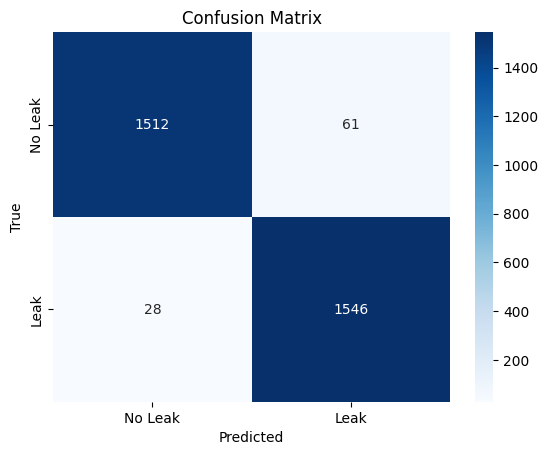

In [20]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

"""

"""

# Best model
model = random_search.best_estimator_

# Predictions on the validation set
y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)

# Accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

# ROC-AUC Score
val_roc_auc = roc_auc_score(label_binarize(y_val, classes=np.unique(y_val)), y_val_prob[:,1])
print("Validation ROC-AUC Score:", val_roc_auc)

# Classification report
print("Classification Report:\n", classification_report(y_val, y_val_pred, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

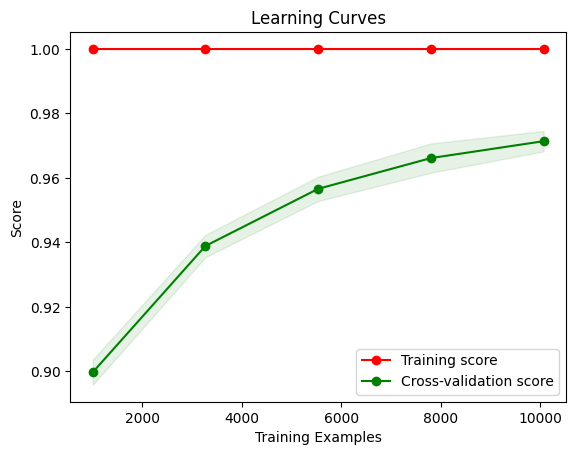

In [21]:
from sklearn.model_selection import learning_curve


# Learning curves with scoring=accuracy
train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

# Calculate mean and standard deviation
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Plot learning curves
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, val_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')
plt.title('Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

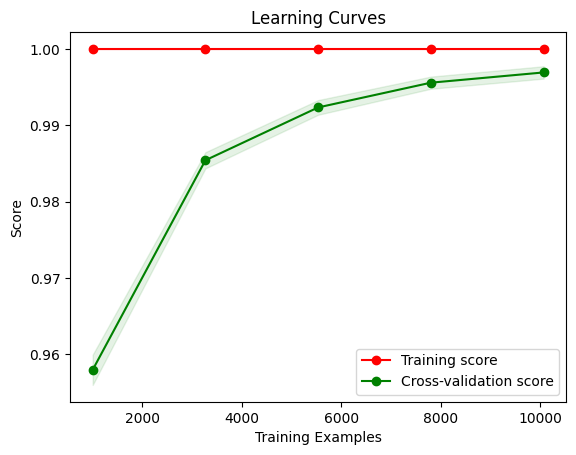

In [22]:
# Learning curves
train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

# Calculate mean and standard deviation
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Plot learning curves
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, val_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')
plt.title('Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

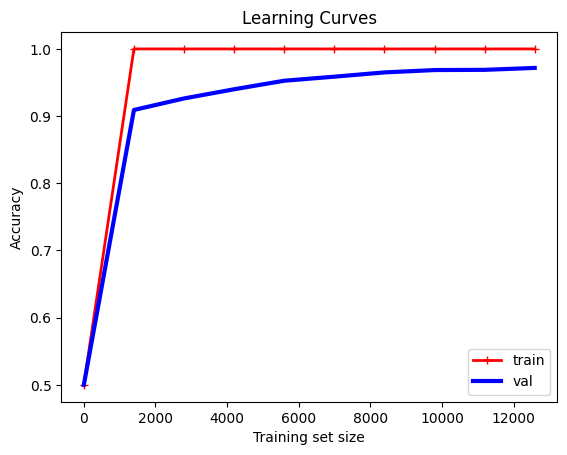

In [23]:
# Helper function to plot learning curves
def plot_learning_curves(model, X_train, y_train, X_val, y_val):
    train_errors, val_errors = [], []
    m_values = np.linspace(max(1, len(np.unique(y_train))), len(X_train), 10, dtype=int)
    for m in m_values:
        if len(np.unique(y_train[:m])) < 2:
            continue
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(accuracy_score(y_train[:m], y_train_predict))
        val_errors.append(accuracy_score(y_val, y_val_predict))
    
    plt.plot(m_values, train_errors, "r-+", linewidth=2, label="train")
    plt.plot(m_values, val_errors, "b-", linewidth=3, label="val")
    plt.legend()
    plt.xlabel('Training set size')
    plt.ylabel('Accuracy')
    plt.title('Learning Curves')
    plt.show()

plot_learning_curves(model, X_train, y_train, X_val, y_val)

Test Accuracy: 0.9715230104246123
Test ROC-AUC Score: 0.9968365363182233
Confusion Matrix:
[[1895   72]
 [  40 1926]]
Classification Report:
              precision    recall  f1-score   support

     No Leak       0.98      0.96      0.97      1967
        Leak       0.96      0.98      0.97      1966

    accuracy                           0.97      3933
   macro avg       0.97      0.97      0.97      3933
weighted avg       0.97      0.97      0.97      3933



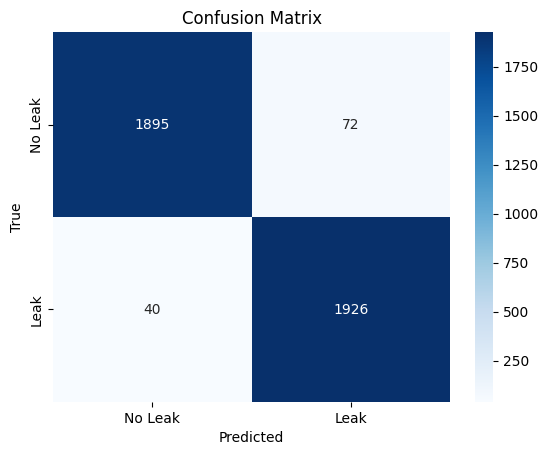

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the test set
y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

# ROC-AUC Score
test_roc_auc = roc_auc_score(label_binarize(y_test, classes=np.unique(y_test)), y_test_prob[:,1])
print("Test ROC-AUC Score:", test_roc_auc)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=class_labels))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
import pickle


with open('rf_leak_pred_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print(f"Trained model saved as svm_leak_pred_model.pkl")

Trained model saved as svm_leak_pred_model.pkl


In [26]:
# Load the trained model from the pkl file
with open('rf_leak_pred_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

print("Model loaded successfully.")

Model loaded successfully.


In [27]:
# Example case scenario
# Note: Ensure the example case has the same feature structure and scaling as the training data
example_case = {
    'Wellhead Temp. (C)': 50.0,
    'Wellhead Press (psi)': 1450.0,
    'MMCFD- gas': 9.0,
    'BOPD (barrel of oil produced per day)': 460.0,
    'BWPD (barrel of water produced per day)': 220.0,
    'BSW - basic solid and water (%)': 5.5,
    'CO2 mol. (%) @ 25 C & 1 Atm.': 1.1,
    'Gas Grav.': 0.67,
}

# Convert to a DataFrame
example_df = pd.DataFrame([example_case])

# Scale the features
example_scaled = scaler.transform(example_df)

# Predict the leak status
example_prediction = loaded_model.predict(example_scaled)
example_prediction_proba = loaded_model.predict_proba(example_scaled)


# convert prediction to integer
example_prediction_int = int(example_prediction[0])

# Format the prediction and probabilities
predicted_leak_status_str = f"Predicted leak status: {class_labels[example_prediction_int]}"
prediction_probabilities_str = "Prediction probabilities:\n" + "\n".join([f"{label}: {prob:.2%}" for label, prob in zip(class_labels, example_prediction_proba[0])])

print(predicted_leak_status_str)
print(prediction_probabilities_str)


Predicted leak status: Leak
Prediction probabilities:
No Leak: 8.95%
Leak: 91.05%
